## Fraud detection case study 

In [115]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('Data2/creditcard.csv')

In [3]:
data.shape

(284807, 31)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data['Class'].mean()

0.001727485630620034

In [6]:
data[data.Class==0].shape

(284315, 31)

In [7]:
data[data.Class==1].shape

(492, 31)

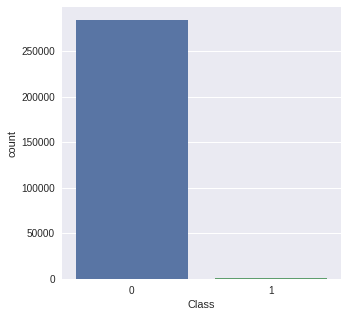

In [21]:
plt.figure(figsize=(5,5))
sns.countplot(data.Class)
plt.show()

## Weighted cost function

### Random forest

In [22]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [191]:
params_forest = {
    'min_samples_leaf': [5,10,20],
    'n_estimators':[10,20]
}

In [193]:
grid_forest = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                          param_grid = params_forest,
                          scoring = 'f1_weighted',
                          cv = StratifiedKFold(5,shuffle=True),
                          n_jobs = -1)
grid_forest.fit(X,y)

print(grid_forest.best_score_)
print(grid_forest.best_params_)

0.999472222638
{'min_samples_leaf': 5, 'n_estimators': 20}


In [194]:
best_forest = grid_forest.best_estimator_

In [195]:
report = classification_report(y,grid_forest.predict(X))
print(report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.94      0.97      0.96       492

avg / total       1.00      1.00      1.00    284807



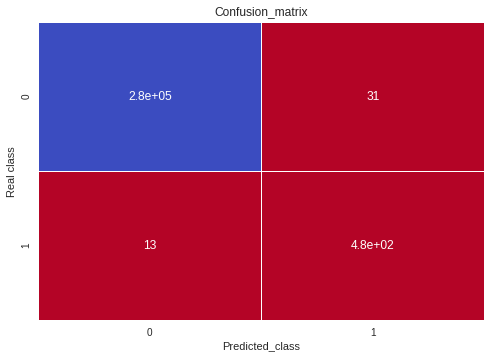

In [196]:
cm = confusion_matrix(y,grid_forest.predict(X))

sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5,cbar=False)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

### Logistic regression

In [205]:
log_weight_pipeline = Pipeline([
    ('scaling',MinMaxScaler()),
    ('log_reg',LogisticRegression(class_weight='balanced'))
]) 

In [207]:
log_weight_param = {
    'log_reg__penalty':['l2'],
    'log_reg__C':[0.01,0.1,1.0],
    'log_reg__class_weight':['balanced',{0:1,1:10},{0:1,1:50},{0:1,1:100}]
}

In [208]:
grid_log_weight = GridSearchCV(log_weight_pipeline,
                              param_grid=log_weight_param,
                              cv=StratifiedKFold(5,shuffle=True),
                              scoring='f1_weighted',
                              n_jobs=-1)
grid_log_weight.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('log_reg', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'log_reg__penalty': ['l2'], 'log_reg__C': [0.01, 0.1, 1.0], 'log_reg__class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [209]:
grid_log_weight.best_score_

0.99928399201234397

In [210]:
grid_log_weight.best_params_

{'log_reg__C': 1.0,
 'log_reg__class_weight': {0: 1, 1: 10},
 'log_reg__penalty': 'l2'}

In [219]:
report = classification_report(y,grid_log_weight.best_estimator_.predict(X))
print(report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.79      0.80      0.80       492

avg / total       1.00      1.00      1.00    284807



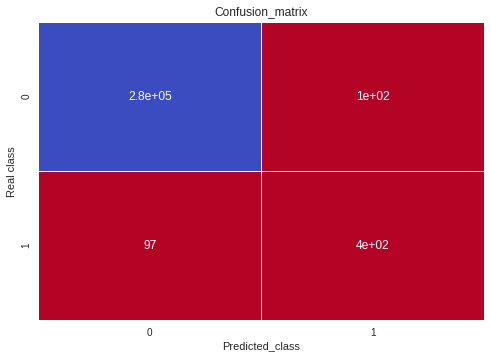

In [220]:
cm = confusion_matrix(y,grid_log_weight.best_estimator_.predict(X))

sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5,cbar=False)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

## Oversampling

### Logistic regression and Random forest

In [213]:
data_0 = data[data['Class']==0]
data_1 = data[data['Class']==1]
print(data_0.shape,data_1.shape)

(284315, 31) (492, 31)


In [214]:
data_1_oversampl = resample(data_1,replace=True,n_samples=data_0.shape[0])
data_1_oversampl.shape

(284315, 31)

In [215]:
data_oversampled = pd.concat([data_0,data_1_oversampl])
data_oversampled.shape

(568630, 31)

In [216]:
data_oversampled.Class.mean()

0.5

In [217]:
X_oversampled = data_oversampled.iloc[:,:-1]
y_overampled = data_oversampled.iloc[:,-1]

In [221]:
pipelines = [Pipeline([('scaler',MinMaxScaler()),
                       ('log_reg',LogisticRegression())]),
             Pipeline([('forest',RandomForestClassifier(class_weight='balanced'))])]
params = [{'log_reg__penalty':['l2'],
           'log_reg__C':[0.01,0.1,1.0],
           'log_reg__class_weight':['balanced',{0:1,1:10},{0:1,1:50},{0:1,1:100}]},
          {'forest__min_samples_leaf': [5,10],
           'forest__n_estimators':[20]}]

0.946894595289
{'log_reg__C': 1.0, 'log_reg__class_weight': 'balanced', 'log_reg__penalty': 'l2'}
             precision    recall  f1-score   support

          0       1.00      0.98      0.99    284315
          1       0.07      0.91      0.13       492

avg / total       1.00      0.98      0.99    284807



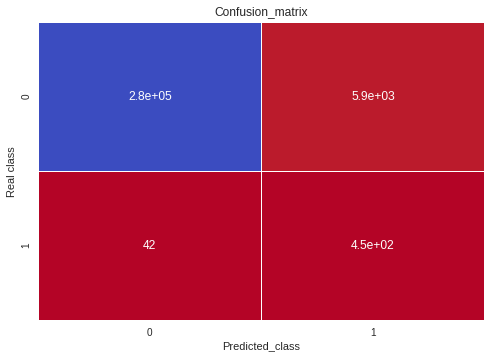

0.99991910381
{'forest__min_samples_leaf': 5, 'forest__n_estimators': 20}
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.94      1.00      0.97       492

avg / total       1.00      1.00      1.00    284807



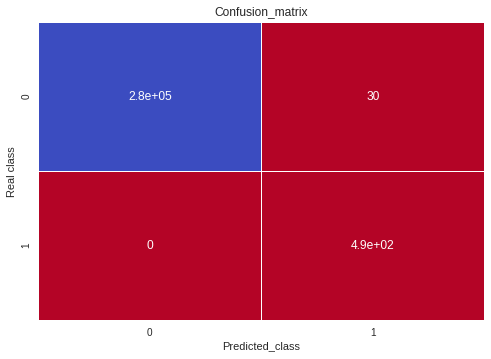

In [223]:
best_score = 0
for pipe,param in zip(pipelines,params): 
    grid = GridSearchCV(pipe,
                        param_grid=param,
                        cv=StratifiedKFold(5,shuffle=True),
                        scoring='f1_weighted',
                        n_jobs=-1)
    grid.fit(X_oversampled,y_overampled)
    if grid.best_score_ > best_score:
        best_model = grid.best_estimator_
     
    print(grid.best_score_)
    print(grid.best_params_)
    
    #report
    print(classification_report(y,grid.best_estimator_.predict(X)))
    
    #confusion matrix
    cm = confusion_matrix(y,grid.best_estimator_.predict(X))
    sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5,cbar=False)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    


## Best model - Random Forest and oversampled dataset

In [230]:
best_model.steps[0]

('forest', RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False))

In [225]:
print(classification_report(y,best_model.predict(X)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.94      1.00      0.97       492

avg / total       1.00      1.00      1.00    284807



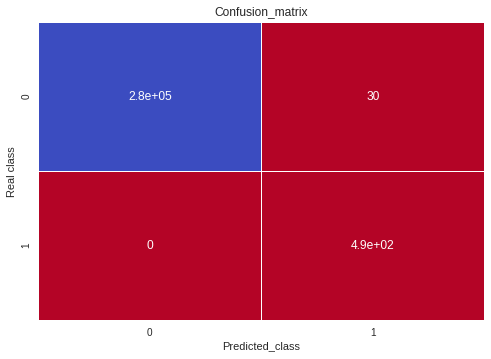

In [226]:
cm = confusion_matrix(y,best_model.predict(X))

sns.heatmap(cm,cmap="coolwarm_r",annot=True,linewidths=0.5,cbar=False)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()